<a href="https://colab.research.google.com/github/JorgeZarama/TFM/blob/main/LSTM_de_Stock_Market_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importar Librería

In [99]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.callbacks import EarlyStopping

Extracción de Datos


In [100]:
# Definir el símbolo de la acción
symbol = 'GOOGL'

# Descargar los datos desde el 1 de enero de 2023 hasta el 31 de diciembre de 2023
df = yf.download(symbol, start='2004-08-20', end='2024-07-31', interval='1d')

# Mostrar las primeras filas del dataframe
df.reset_index(inplace=True)
df['Date'] = pd.to_datetime(df['Date'])

print(df.head())


[*********************100%***********************]  1 of 1 completed

        Date      Open      High       Low     Close  Adj Close     Volume
0 2004-08-20  2.527778  2.729730  2.515015  2.710460   2.703765  456686856
1 2004-08-23  2.771522  2.839840  2.728979  2.737738   2.730976  365122512
2 2004-08-24  2.783784  2.792793  2.591842  2.624374   2.617892  304946748
3 2004-08-25  2.626627  2.702703  2.599600  2.652653   2.646101  183772044
4 2004-08-26  2.626376  2.701451  2.619119  2.700450   2.693780  141897960


Revisar la Data

In [101]:
display(df.describe(include='all'))
df.info()

,Date,Open,High,Low,Close,Adj Close,Volume
count,5019,5019.000000,5019.000000,5019.000000,5019.000000,5019.000000,5.019000e+03
mean,2014-08-08 10:01:04.554692096,45.309724,45.784195,44.843776,45.325722,45.215203,1.173464e+08
min,2004-08-20 00:00:00,2.482232,2.546046,2.475976,2.502753,2.496571,9.312000e+06
25%,2009-08-13 12:00:00,13.097973,13.210085,12.943944,13.098223,13.065869,3.104200e+07
50%,2014-08-08 00:00:00,27.608999,27.850000,27.345501,27.584499,27.516365,5.975219e+07
75%,2019-08-03 12:00:00,60.459000,61.028749,60.110748,60.546499,60.396944,1.418720e+08
max,2024-07-30 00:00:00,190.309998,191.750000,189.029999,191.179993,190.926636,1.643023e+09
std,NaN,42.958750,43.431968,42.522119,42.989926,42.888262,1.475160e+08


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5019 entries, 0 to 5018
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       5019 non-null   datetime64[ns]
 1   Open       5019 non-null   float64       
 2   High       5019 non-null   float64       
 3   Low        5019 non-null   float64       
 4   Close      5019 non-null   float64       
 5   Adj Close  5019 non-null   float64       
 6   Volume     5019 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 274.6 KB


Gráficamos el valor de la acción

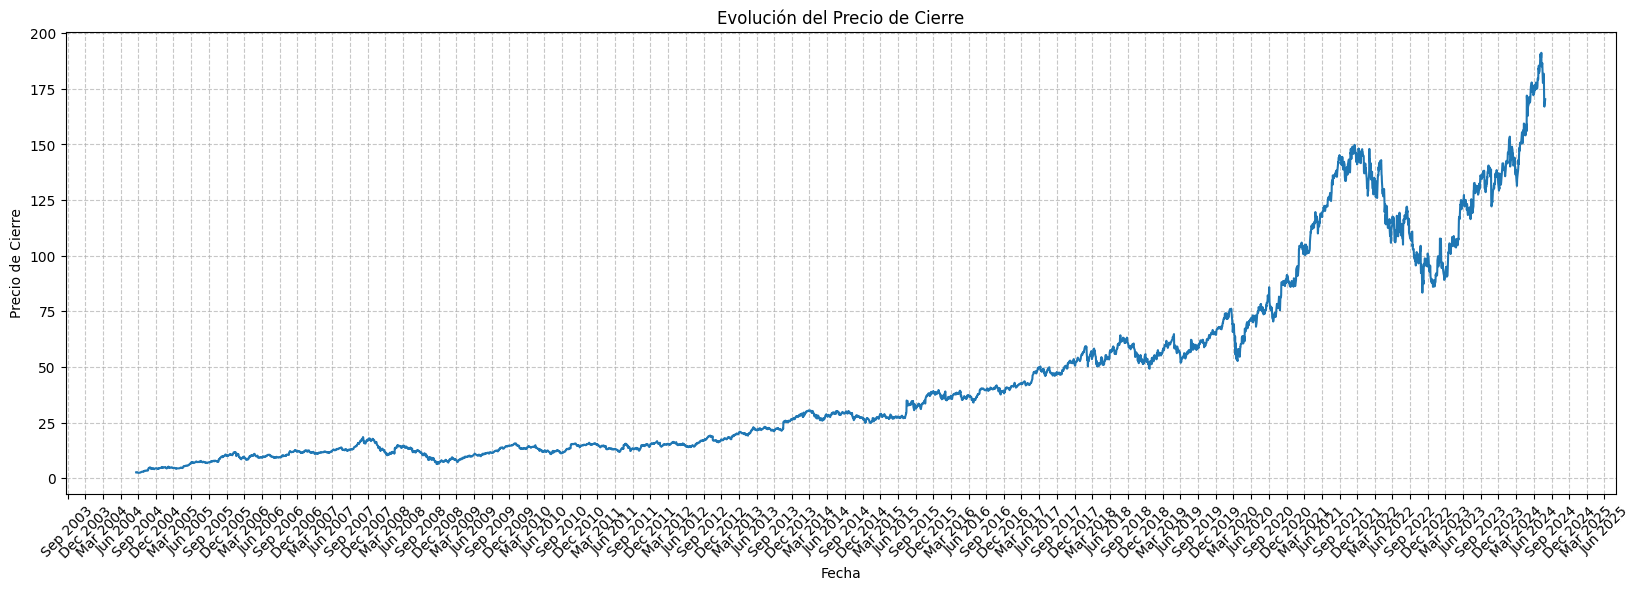

In [102]:
# Convertir la columna 'Date' a un formato de fecha de pandas, especificando el formato si es necesario
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')  # Ajusta el formato si es diferente

# Filtrar los datos por el rango de fechas

df_filtrado = df[(df['Date'] >= '2004-08-20') & (df['Date'] <= '2024-07-31')]

# Crear el gráfico de línea
plt.figure(figsize=(20, 6))
sns.lineplot(x='Date', y='Close', data=df_filtrado)

# Personalizar el eje x para mostrar meses y años
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)

# Agregar título y etiquetas a los ejes
plt.title('Evolución del Precio de Cierre')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre')

# Agregar una cuadrícula para facilitar la lectura
plt.grid(True, linestyle='--', alpha=0.7)

# Mostrar el gráfico
plt.show()

In [103]:
# # Crear la columna de tendencia respecto al día anterior
# df['Tendencia_Cambio_Superior'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)

# Calcular el porcentaje de cambio respecto al día anterior
df['Porcentaje_Cambio_Superior'] = ((df['Close'].shift(-1) - df['Close']) / df['Close']) * 100




In [104]:
#Sacamos los valores con NaN

df = df.iloc[:-1]
display(df.head(10))
display(df.tail(10))

,Date,Open,High,Low,Close,Adj Close,Volume,Porcentaje_Cambio_Superior
0,2004-08-20,2.527778,2.729730,2.515015,2.710460,2.703765,456686856,1.006395
1,2004-08-23,2.771522,2.839840,2.728979,2.737738,2.730976,365122512,-4.140790
2,2004-08-24,2.783784,2.792793,2.591842,2.624374,2.617892,304946748,1.077555
3,2004-08-25,2.626627,2.702703,2.599600,2.652653,2.646101,183772044,1.801855
4,2004-08-26,2.626376,2.701451,2.619119,2.700450,2.693780,141897960,-1.630988
5,2004-08-27,2.705205,2.718218,2.644895,2.656406,2.649844,124235640,-3.900115
6,2004-08-30,2.634635,2.639890,2.552803,2.552803,2.546498,103935960,0.352902
7,2004-08-31,2.560060,2.595345,2.556557,2.561812,2.555484,98357544,-2.070913
8,2004-09-01,2.570070,2.576827,2.494244,2.508759,2.502562,182765052,1.256840
9,2004-09-02,2.482232,2.561812,2.475976,2.540290,2.534015,302373324,-1.477670


,Date,Open,High,Low,Close,Adj Close,Volume,Porcentaje_Cambio_Superior
5008,2024-07-16,187.360001,188.679993,183.369995,183.919998,183.676270,18290700,-1.576769
5009,2024-07-17,182.970001,183.550003,179.899994,181.020004,180.780121,20734100,-1.839577
5010,2024-07-18,181.929993,182.500000,176.470001,177.690002,177.454529,25315700,-0.016883
5011,2024-07-19,178.880005,180.289993,177.130005,177.660004,177.424576,18881900,2.257117
5012,2024-07-22,180.589996,182.699997,180.229996,181.669998,181.429245,24100300,0.066051
5013,2024-07-23,182.050003,183.610001,181.539993,181.789993,181.549088,36352700,-5.038775
5014,2024-07-24,173.600006,176.190002,171.820007,172.630005,172.401230,49585200,-3.099117
5015,2024-07-25,172.520004,173.419998,167.190002,167.279999,167.058319,44852000,-0.167383
5016,2024-07-26,167.149994,168.089996,164.059998,167.000000,166.778687,41336900,1.514969
5017,2024-07-29,168.830002,170.429993,167.990005,169.529999,169.305344,20293800,0.448295


Seleccionar las características y la variable objetivo

In [105]:
# Seleccionar la columna objetivo y las características
features = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
target = 'Porcentaje_Cambio_Superior'

# Escalar las características de manera independiente en el conjunto de entrenamiento
scaler = MinMaxScaler(feature_range=(0, 1))

# Separar en conjunto de entrenamiento y prueba (80% entrenamiento, 20% prueba)
train_size = int(len(df) * 0.8)
train_data, test_data = df[:train_size], df[train_size:]

# Escalar solo el conjunto de entrenamiento
scaled_train_data = scaler.fit_transform(train_data[features])
scaled_test_data = scaler.transform(test_data[features])

# Escalar el objetivo de manera separada
target_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_target = target_scaler.fit_transform(train_data[[target]])
scaled_test_target = target_scaler.transform(test_data[[target]])

# Convertir a numpy arrays
scaled_train_data = np.array(scaled_train_data)
scaled_test_data = np.array(scaled_test_data)
scaled_train_target = np.array(scaled_train_target)
scaled_test_target = np.array(scaled_test_target)

# Función para crear secuencias
def create_sequences(data, target, time_steps=5):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(target[i + time_steps])
    return np.array(X), np.array(y)

# Crear secuencias con una ventana de tiempo de 5 días
time_steps = 30
X_train, y_train = create_sequences(scaled_train_data, scaled_train_target, time_steps)
X_test, y_test = create_sequences(scaled_test_data, scaled_test_target, time_steps)

Arquitectura del Modelo

In [110]:
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))  # Agregar dropout para evitar overfitting
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=50, activation='relu'))
model.add(Dense(units=1))  # Capa de salida

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Entrenamiento del Modelo

In [111]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(X_train, y_train, epochs=100, batch_size=30, validation_data=(X_test, y_test), callbacks=[early_stop])

Epoch 1/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 12s 59ms/step - loss: 0.0181 - val_loss: 0.0051
Epoch 2/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - loss: 0.0047 - val_loss: 0.0056
Epoch 3/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - loss: 0.0042 - val_loss: 0.0051
Epoch 4/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - loss: 0.0043 - val_loss: 0.0039
Epoch 5/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - loss: 0.0040 - val_loss: 0.0046
Epoch 6/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - loss: 0.0042 - val_loss: 0.0039
Epoch 7/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - loss: 0.0041 - val_loss: 0.0039
Epoch 8/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - loss: 0.0039 - val_loss: 0.0042
Epoch 9/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - loss: 0.0038 - val_loss: 0.0040
Epoch 10/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 0.0036 - val_loss: 0.0038
Epoch 11/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 12/100
133/133 ━━━━

Evaluación de mi modelo

In [112]:

# Evaluar el modelo en el conjunto de prueba
test_loss = model.evaluate(X_test, y_test)

# Predicción
predictions = model.predict(X_test)

# Desescalar las predicciones y los valores verdaderos
predictions_descaled = target_scaler.inverse_transform(predictions)
y_test_descaled = target_scaler.inverse_transform(y_test)

# Calcular métricas adicionales
mae = mean_absolute_error(y_test_descaled, predictions_descaled)
mse = mean_squared_error(y_test_descaled, predictions_descaled)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_descaled, predictions_descaled)

# Mostrar las métricas
print(f"Test Loss (MSE): {test_loss}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0036
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
Test Loss (MSE): 0.0038081062957644463
Mean Absolute Error (MAE): 1.4133320094842325
Mean Squared Error (MSE): 3.80880872728422
Root Mean Squared Error (RMSE): 1.9516169519873052
R-squared (R²): -0.0012441023482610003


In [115]:
display(predictions)

array([[0.37156725],
       [0.3715401 ],
       [0.37151787],
       [0.3715011 ],
       [0.37148404],
       [0.37144503],
       [0.3714011 ],
       [0.37135908],
       [0.37132078],
       [0.37129048],
       [0.3712632 ],
       [0.371234  ],
       [0.37121397],
       [0.37119958],
       [0.37119183],
       [0.3711991 ],
       [0.37121433],
       [0.3712313 ],
       [0.37124008],
       [0.37124914],
       [0.37125325],
       [0.3712414 ],
       [0.3712403 ],
       [0.3712558 ],
       [0.3712884 ],
       [0.37132132],
       [0.37135413],
       [0.37138134],
       [0.37138495],
       [0.3713981 ],
       [0.37141615],
       [0.3714407 ],
       [0.37147155],
       [0.3714985 ],
       [0.37150303],
       [0.37144378],
       [0.3714138 ],
       [0.37141293],
       [0.3713974 ],
       [0.37140724],
       [0.37145248],
       [0.3714956 ],
       [0.37155607],
       [0.3716188 ],
       [0.371682  ],
       [0.37173486],
       [0.37178242],
       [0.371

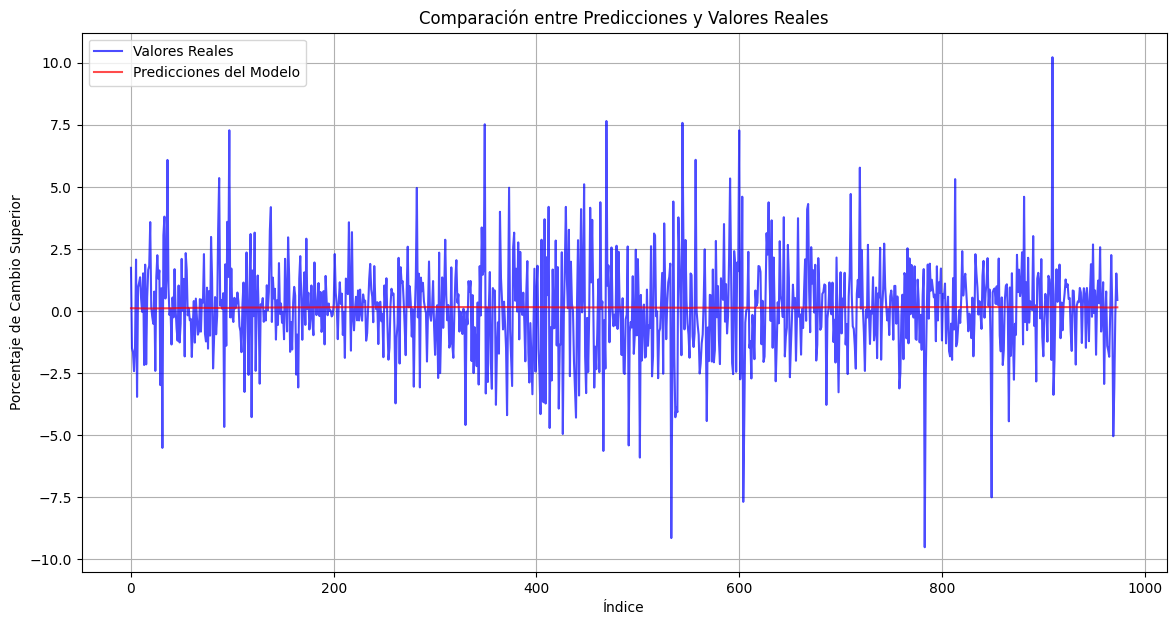

In [113]:


# Crear el gráfico
plt.figure(figsize=(14, 7))
plt.plot(y_test_descaled, label='Valores Reales', color='blue', alpha=0.7)
plt.plot(predictions_descaled, label='Predicciones del Modelo', color='red', alpha=0.7)
plt.xlabel('Índice')
plt.ylabel('Porcentaje de Cambio Superior')
plt.title('Comparación entre Predicciones y Valores Reales')
plt.legend()
plt.grid(True)
plt.show()